#### Нашей компании нужно сгруппировать клиентов для АБ-тестов. Алгоритм группировки очень простой - взять ID клиента (состоит из 5-7 цифр, например 7412567) и найти сумму всех его цифр. Получившееся число и является номером группы, в которую входит данный клиент. Для того, чтобы понять, насколько хорош такой простой алгоритм, тебе нужно написать следующие диагностические функции:
<ol> 
    <li>Функция, которая подсчитывает число покупателей, попадающих в каждую группу, если нумерация ID
     сквозная и начинается с 0. На вход функция получает целое число n_customers (количество клиентов).</li>
    <li>Функция, аналогичная первой, если ID начинается с произвольного числа.
     На вход функция получает целые числа: n_customers (количество клиентов) и n_first_id (первый ID в последовательности).</li>
</ol>
 
#### Напишите код функций на Python и оформите его в репозиторий Github. В форму ответа вставьте ссылку на репозиторий, убедитесь, что он публичный.

#### Дополнительно к работоспособности оценим:

<ol>
<li>читабельность и аккуратность кода;</li>
<li>производительность кода.</li>
</ol>

### First of all, we need an encoding algorithm which takes an id and encodes it to the group number

In [1]:
# Importing id-encoding functions from custom module

from AB_algorithm_diagnostics import _id_to_group_encode_v1, _id_to_group_encode_v2

Double check whether they both are correct

In [2]:
print(_id_to_group_encode_v1(1237457))    # 29
print(_id_to_group_encode_v1(139581237))  # 39

print(_id_to_group_encode_v2(1237457))    # 29
print(_id_to_group_encode_v2(139581237))  # 39

29
39
29
39


Finding out which way encodes faster:

In [5]:
from timeit import timeit

N_trials = 10 ** 7
print(timeit('_id_to_group_encode_v1(1237457)',
             setup='from __main__ import _id_to_group_encode_v1', number=N_trials))
print(timeit('_id_to_group_encode_v2(1237457)',
             setup='from __main__ import _id_to_group_encode_v2', number=N_trials))

7.277382999999986
3.5089437999999973


For 10 ** 7 trials results are 7.28 and 3.51 seconds correspondingly, so we will stick with v2 method

### Now, let's move on to the problem itself. First approach:

In [3]:
from AB_algorithm_diagnostics import group_distribution_v1, group_distribution_v2

Let's look how people are distributed among groups when we start numeration from 0 and from random number:

In [6]:
N_customers = 10 ** 6

In [7]:
from random import randint

In [8]:
%%timeit
dist_0 = group_distribution_v1(N_customers)
dist_1 = group_distribution_v1(N_customers, randint(0, N_customers - 1))

758 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
dist_0 = group_distribution_v2(N_customers)
dist_1 = group_distribution_v2(N_customers, randint(0, N_customers - 1))

758 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Both methods are practically equal, so we will stick with the first one (v1)

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [10]:
df_0 = pd.DataFrame(dist_0, columns=['Fraction_of_people'])
df_0['Number_of_group'] = pd.Series(list(range(len(dist_0))), name='Number_of_group')
df_0.tail()

,Fraction_of_people,Number_of_group
50,0.000126,50
51,0.000056,51
52,0.000021,52
53,0.000006,53
54,0.000001,54


In [76]:
df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')
df_1.tail()

,Fraction_of_people,Number_of_group
50,0.000127,50
51,0.000056,51
52,0.000021,52
53,0.000006,53
54,0.000001,54


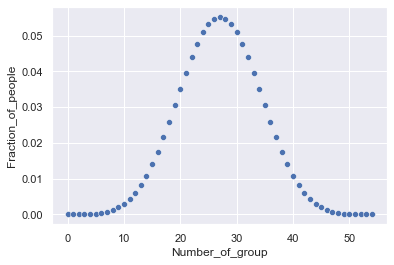

In [16]:
sns.scatterplot(x='Number_of_group', y='Fraction_of_people', data=df_0);

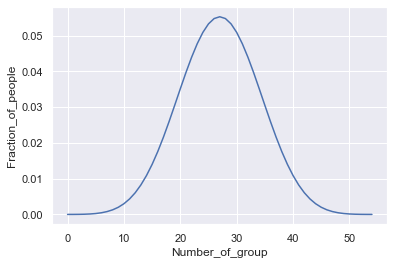

In [21]:
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_0);

#### This seems like normal distribution, lets try to approximate

In [30]:
from scipy.stats import norm
import numpy as np

In [72]:
_loc = 27.1
_scale = 7.2

In [73]:
appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in df_0['Number_of_group']]

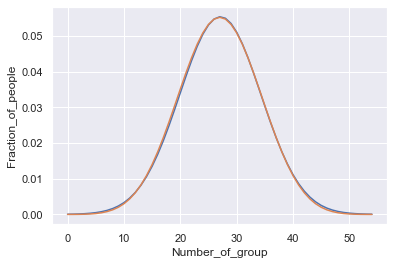

In [74]:
sns.lineplot(x=df_0['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_0)
plt.show()

#### So, by hand I selected (in about 2 minutes) mean = 27.1 and std = 7.2, and seems like distributions are pretty close. Now, let's how does it go with randomly selected starting point

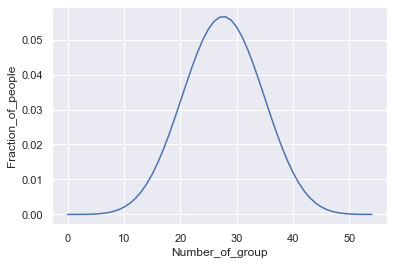

In [77]:
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1);

It doesn't seems like anything changed. Let's compare with our normal distribution (27.1, 7.2)

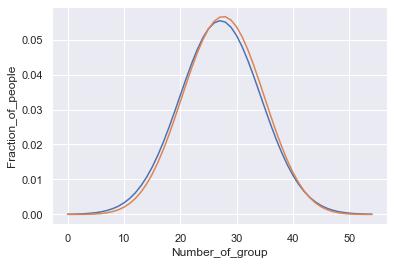

In [78]:
sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

#### Well, there is a little shift, but it is almost imposible to spot. Let's find out how big n_first_id should be to detect significant difference

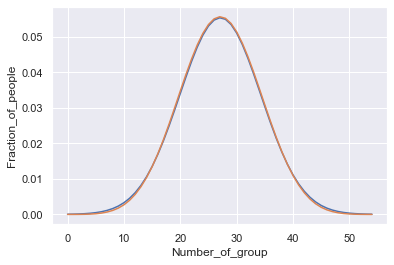

In [79]:
dist_1 = group_distribution_v1(N_customers, N_customers // 10)

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

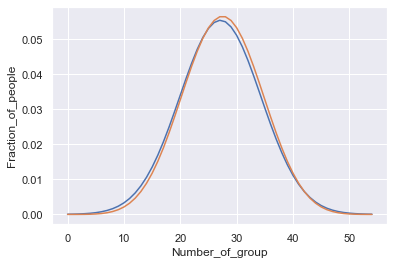

In [88]:
dist_1 = group_distribution_v1(N_customers, N_customers // 2)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

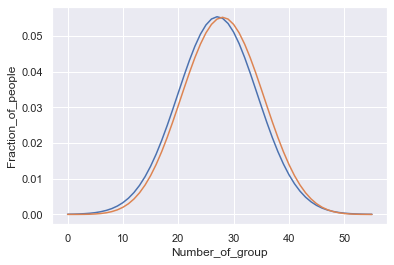

In [89]:
dist_1 = group_distribution_v1(N_customers, N_customers)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

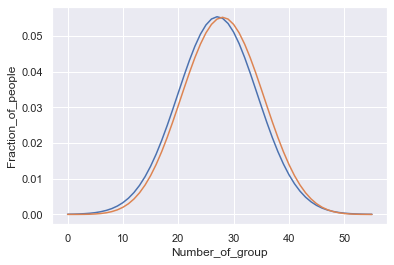

In [90]:
dist_1 = group_distribution_v1(N_customers, N_customers * 10)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

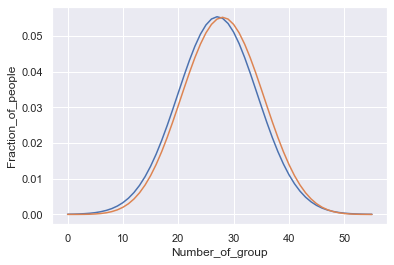

In [91]:
dist_1 = group_distribution_v1(N_customers, N_customers * 100)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

### We can observe, that distribution doesn't really changes when we increase starting point, and seems like it  more depends on N_customers:

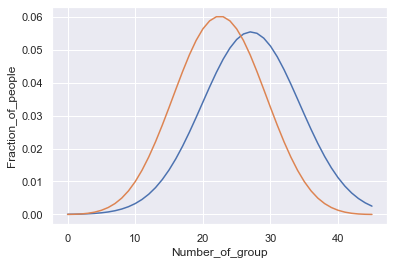

In [93]:
dist_1 = group_distribution_v1(N_customers // 10, 0)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()

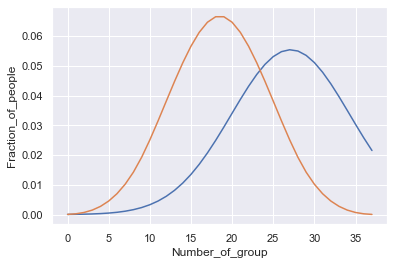

In [94]:
dist_1 = group_distribution_v1(N_customers // 50, 0)

appx_norm_0 = [norm.pdf(i, loc=_loc, scale=_scale) for i in range(len(dist_1))]

df_1 = pd.DataFrame(dist_1, columns=['Fraction_of_people'])
df_1['Number_of_group'] = pd.Series(list(range(len(dist_1))), name='Number_of_group')

sns.lineplot(x=df_1['Number_of_group'], y=appx_norm_0)
sns.lineplot(x='Number_of_group', y='Fraction_of_people', data=df_1)
plt.show()